这一章有两个部分，一个是利用异常检测算法识别网络中不工作的服务器，另外一个是利用“协同过滤”算法构造一个电影的推荐系统。

## 1. Anomaly Detection

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.io import loadmat 

In [92]:
data = loadmat('ex8data1.mat')
X = data['X']
X

array([[ 13.04681517,  14.74115241],
       [ 13.40852019,  13.7632696 ],
       [ 14.19591481,  15.85318113],
       [ 14.91470077,  16.17425987],
       [ 13.57669961,  14.04284944],
       [ 13.92240251,  13.40646894],
       [ 12.82213164,  14.22318782],
       [ 15.67636615,  15.89169137],
       [ 16.16287532,  16.20299807],
       [ 12.66645095,  14.89908374],
       [ 13.98454962,  12.95800822],
       [ 14.06146043,  14.54908874],
       [ 13.38988671,  15.56202142],
       [ 13.39350475,  15.62698794],
       [ 13.97900926,  13.28061494],
       [ 14.16791259,  14.46583829],
       [ 13.96176145,  14.75182421],
       [ 14.45899735,  15.07018563],
       [ 14.58476372,  15.82743424],
       [ 12.07427074,  13.0671109 ],
       [ 13.5491294 ,  15.53827677],
       [ 13.98625042,  14.78776304],
       [ 14.96991942,  16.51830493],
       [ 14.25576597,  15.29427277],
       [ 15.33425   ,  16.12469989],
       [ 15.6350487 ,  16.49094477],
       [ 13.62081292,  15.45947525],
 

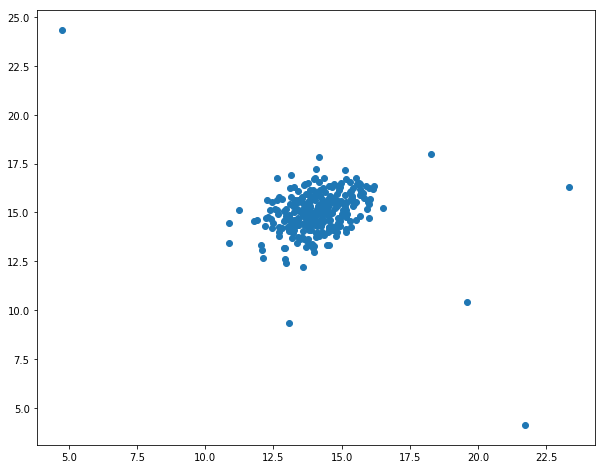

In [3]:
fig, ax = plt.subplots(figsize=(10, 8))
ax.scatter(X[:, 0], X[:, 1])
plt.show()

可以较为清晰的看到异常的点

### 1.1 gaussian distribution

$p\left( x;\mu ,\sigma ^{2}\right) =\dfrac {1}{\sqrt {2\pi \sigma ^{2}}}e^{-\dfrac {\left( x-\mu \right) ^{2}}{2\sigma ^{2}}}$

### 1.2 estimating parameters for a gaussian

$\mu _{i}=\dfrac {1}{m}\sum ^{m}_{j=1}x^{\left( j\right) }_{i}$

$\sigma ^{2}_{i}=\dfrac {1}{m}\sum ^{m}_{j=1}\left( x_{i}\left( j\right) -\mu _{i}\right) ^{2}$

In [7]:
def estimate_gaussian(X):
    mu = X.mean(axis=0)
    sigma = X.std(axis=0)
    
    return mu, sigma

In [93]:
mu, sigma = estimate_gaussian(X)
mu, sigma

(array([ 14.11222578,  14.99771051]), array([ 1.35374717,  1.3075723 ]))

### 1.3 selecting the threshold

根据阈值判断可能性，可能性的小的更有可能是异常点

In [88]:
# 已有数据集
Xval = data['Xval']
yval = data['yval']

Xval.shape, yval.shape

((307, 2), (307, 1))

计算概率密度

In [12]:
def compute_probability(mu, sigma, X):
    p = 1 / np.sqrt(2 * np.pi * sigma ** 2)
    exp = np.exp(-(X - mu)**2/(2*sigma**2))
    p = p * exp
    return p

In [18]:
compute_probability(mu[0], sigma[0], 15)

0.23767635105892451

也可以传入数据，计算数据集中每个点的概率密度

In [21]:
compute_probability(mu[0], sigma[0], X[:, 0])[:10]

array([ 0.21620977,  0.25745208,  0.29413223,  0.24721192,  0.27251547,
        0.2918119 ,  0.18713958,  0.15117648,  0.09356331,  0.166609  ])

保存概率密度值

In [46]:
m, n = X.shape
p = np.zeros((m, 1))
p = compute_probability(mu[0], sigma[0], X[:, 0]) * compute_probability(mu[1], sigma[1], X[:, 1])
p = p.reshape((m, 1))
p.shape

(307, 1)

计算验证集概率密度值

In [94]:
pval = np.zeros((m, 1))
pval = compute_probability(mu[0], sigma[0], Xval[:, 0]) * compute_probability(mu[1], sigma[1], Xval[:, 1])
pval = pval.reshape((m, 1))

阈值的选择是根据 F1-score 来判断的

$F_{1}=\dfrac {2\cdot prec\cdot rec}{prec+rec}$

$prec=\dfrac {tp}{tp+fp}$

$rec=\dfrac {tp}{tp+fn}$

In [66]:
def select_threshold(pval, yval):
    best_epison = 0
    best_f1 = 0
    f1 = 0
    
    step = (pval.max() - pval.min()) / 1000
    
    for epsilon in np.arange(pval.min(), pval.max(), step):
        preds = pval < epsilon
        tp = np.sum(np.logical_and(preds == 1, yval == 1)).astype(float)
        fp = np.sum(np.logical_and(preds == 1, yval == 0)).astype(float)
        fn = np.sum(np.logical_and(preds == 0, yval == 1)).astype(float)
        
        precision = tp / (tp + fp)
        recall = tp / (tp + fn)
        f1 = (2 * precision * recall) / (precision + recall)
        
        if f1 > best_f1:
            best_f1 = f1
            best_epison = epsilon
    return best_epison, best_f1

In [95]:
epsilon, f1 = select_threshold(pval, yval)
epsilon, f1

E:\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in double_scalars
  


(8.9908527792694918e-05, 0.87500000000000011)

In [68]:
outliers = np.where(p < epsilon)
outliers

(array([300, 301, 303, 304, 305, 306], dtype=int64),
 array([0, 0, 0, 0, 0, 0], dtype=int64))

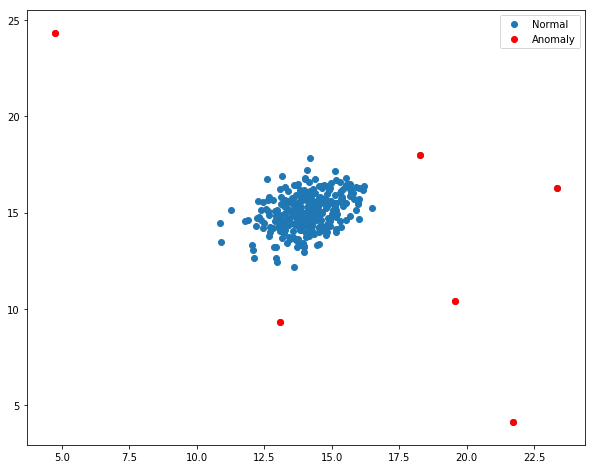

In [70]:
fig, ax = plt.subplots(figsize=(10, 8))
ax.scatter(X[:, 0], X[:, 1], label='Normal')
ax.scatter(X[outliers[0], 0], X[outliers[0], 1], c='r', label='Anomaly')
plt.legend(loc='best')
plt.show()

可以很清楚的看出异常值

### 1.4 high dimensioanl dataset

对于高维的数据，高斯分布也变得复杂，需要计算协方差矩阵，除此之外，解决思路与上面是一致的。

In [100]:
data2 = loadmat('ex8data2.mat')
X = data2['X']
Xval = data2['Xval']
yval = data2['yval']
X.shape, Xval.shape, yval.shape

((1000, 11), (100, 11), (100, 1))

In [105]:
# 计算协方差矩阵
X = np.mat((X - X.mean(axis=0)) / X.std(axis=0))
sigma = np.cov(X.T)
sigma

array([[ 1.001001  ,  0.02307986,  0.01161028,  0.00181935,  0.07420418,
        -0.00720554, -0.05806921,  0.06785482, -0.02718041,  0.05961267,
        -0.05237602],
       [ 0.02307986,  1.001001  , -0.0399101 , -0.0688857 ,  0.02943721,
         0.04465292,  0.02545366,  0.11043389,  0.10574457, -0.07870864,
         0.14897379],
       [ 0.01161028, -0.0399101 ,  1.001001  ,  0.03741508,  0.05358725,
        -0.04684003,  0.04993521,  0.03049285,  0.17377612,  0.09159422,
        -0.05241558],
       [ 0.00181935, -0.0688857 ,  0.03741508,  1.001001  ,  0.02572627,
         0.01644659,  0.0550358 ,  0.03000705, -0.08373483,  0.024796  ,
        -0.01889772],
       [ 0.07420418,  0.02943721,  0.05358725,  0.02572627,  1.001001  ,
         0.01548925,  0.08986146, -0.03349427,  0.0169999 ,  0.05909549,
        -0.00901494],
       [-0.00720554,  0.04465292, -0.04684003,  0.01644659,  0.01548925,
         1.001001  ,  0.03199682,  0.01501516, -0.00234088, -0.04311864,
         0.018

In [106]:
mu = X.mean(axis=0)
mu

matrix([[ -7.81597009e-17,  -1.43884904e-16,   3.19744231e-17,
          -2.84217094e-16,   3.41948692e-17,  -4.08562073e-17,
           8.26005930e-17,  -3.19744231e-17,  -1.00364161e-16,
          -3.55271368e-17,   1.82076576e-17]])

In [124]:
def compute_multi_probability(mu, sigma, X):
    m, n = X.shape
    p = 1 / ((2 * np.pi)**(n/2)*(np.linalg.norm(sigma)**0.5))
    exp = np.exp(-1/2*(X-mu) * np.mat(sigma).I * (X - mu).T)
    p = p * exp
    return p

In [125]:
p = compute_multi_probability(mu, sigma, X)
p.shape

(1000, 1000)

这个地方还有点问题，之后处理。

## 2. recommender systems

### 2.1 movie ratings dataset

In [2]:
data = loadmat('ex8_movies.mat')
data

{'R': array([[1, 1, 0, ..., 1, 0, 0],
        [1, 0, 0, ..., 0, 0, 1],
        [1, 0, 0, ..., 0, 0, 0],
        ..., 
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint8),
 'Y': array([[5, 4, 0, ..., 5, 0, 0],
        [3, 0, 0, ..., 0, 0, 5],
        [4, 0, 0, ..., 0, 0, 0],
        ..., 
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint8),
 '__globals__': [],
 '__header__': b'MATLAB 5.0 MAT-file, Platform: GLNXA64, Created on: Thu Dec  1 17:19:26 2011',
 '__version__': '1.0'}

Y是包含从1到5的电影评分，电影的数量*用户的数量，R是用户是否打分的矩阵，R(i, j)=1表示用户j对于电影i打分了

In [3]:
Y = data['Y']
R = data['R']
Y.shape, R.shape

((1682, 943), (1682, 943))

In [7]:
# 查看电影平均值
Y[1, R[1, :] == 1].mean()

3.2061068702290076

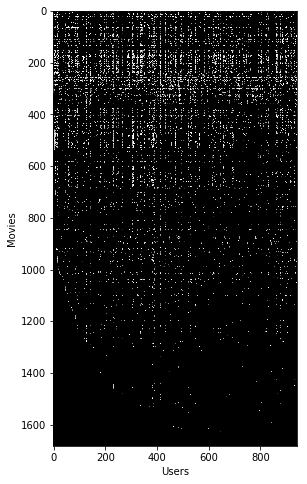

In [9]:
# 可视化
fig, ax = plt.subplots(figsize=(10, 8))
ax.imshow(Y, cmap='gray')
plt.xlabel('Users')
plt.ylabel('Movies')
plt.show()

### 2.2 collaborative filtering learning algorithm

#### 2.2.1 collaborative filtering cost function

In [33]:
def cost(params, Y, R, num_features):
    Y = np.mat(Y) # (1682, 943)
    R = np.mat(R) # (1682, 943)
    num_movies, num_users = Y.shape
    
    X = params[:num_movies * num_features].reshape((num_movies, num_features)) # (1682, features)
    Theta = params[num_movies * num_features:].reshape((num_users, num_features)) # (943. features)
    Theta = np.mat(Theta)
    
    J =  0
    
    # compute error
    error = np.multiply(((X * Theta.T) - Y), R)
    squared_error = np.power(error, 2)
    J = (1 / 2) * np.sum(squared_error)
    
    return J

In [15]:
params_data = loadmat('ex8_movieParams.mat')
X = params_data['X']
Theta = params_data['Theta']
X.shape, Theta.shape

((1682, 10), (943, 10))

简单验证一下

In [34]:
users = 4
movies = 5
features = 3

X_sub = X[:movies, :features]
Theta_sub = Theta[:users, :features]
Y_sub = Y[:movies, :users]
R_sub = R[:movies, :users]

params = np.concatenate((np.ravel(X_sub), np.ravel(Theta_sub)))
cost(params, Y_sub, R_sub, features)

22.224603725685675

#### 2.2.2 collaborative filtering gradient

In [35]:
def gradient(params, Y, R, num_features):
    Y = np.mat(Y) # (1682, 943)
    R = np.mat(R) # (1682, 943)
    num_movies, num_users = Y.shape
    
    X = params[:num_movies * num_features].reshape((num_movies, num_features)) # (1682, features)
    Theta = params[num_movies * num_features:].reshape((num_users, num_features)) # (943. features)
    Theta = np.mat(Theta)
    
    J =  0
    
    # compute error
    error = np.multiply(((X * Theta.T) - Y), R) # (1682, 943)
    squared_error = np.power(error, 2)
    J = (1 / 2) * np.sum(squared_error)
    
    # calculate the gradient
    X_grad = error * Theta # (1682, features)
    Theta_grad = error.T * X # (943, features)
    
    grad = np.concatenate((np.ravel(X_grad), np.ravel(Theta_grad)))
    
    return J, grad

In [37]:
J, grad = gradient(params, Y_sub, R_sub, features)
J, grad

(22.224603725685675,
 array([ -2.52899165,   7.57570308,  -1.89979026,  -0.56819597,
          3.35265031,  -0.52339845,  -0.83240713,   4.91163297,
         -0.76677878,  -0.38358278,   2.26333698,  -0.35334048,
         -0.80378006,   4.74271842,  -0.74040871, -10.5680202 ,
          4.62776019,  -7.16004443,  -3.05099006,   1.16441367,
         -3.47410789,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ]))

#### 2.2.3 regularized cost function

In [38]:
def gradient_regularized(params, Y, R, num_features, learning_rate=1):
    Y = np.mat(Y) # (1682, 943)
    R = np.mat(R) # (1682, 943)
    num_movies, num_users = Y.shape
    
    X = params[:num_movies * num_features].reshape((num_movies, num_features)) # (1682, features)
    Theta = params[num_movies * num_features:].reshape((num_users, num_features)) # (943. features)
    Theta = np.mat(Theta)
    
    J =  0
    
    # compute error
    error = np.multiply(((X * Theta.T) - Y), R) # (1682, 943)
    squared_error = np.power(error, 2)
    J = (1 / 2) * np.sum(squared_error)
    
    # add regularization
    J = J + ((learning_rate/2) * np.sum(np.power(Theta, 2))) + ((learning_rate/2) * np.sum(np.power(X, 2)))
    
    # calculate the gradient
    X_grad = error * Theta + (learning_rate * X) # (1682, features)
    Theta_grad = error.T * X + (learning_rate * Theta) # (943, features)
    
    grad = np.concatenate((np.ravel(X_grad), np.ravel(Theta_grad)))
    
    return J, grad

In [39]:
J, grad = gradient_regularized(params, Y_sub, R_sub, features, 1.5)
J, grad

(31.344056244274221,
 array([ -0.95596339,   6.97535514,  -0.10861109,   0.60308088,
          2.77421145,   0.25839822,   0.12985616,   4.0898522 ,
         -0.89247334,   0.29684395,   1.06300933,   0.66738144,
          0.60252677,   4.90185327,  -0.19747928, -10.13985478,
          2.10136256,  -6.76563628,  -2.29347024,   0.48244098,
         -2.99791422,  -0.64787484,  -0.71820673,   1.27006666,
          1.09289758,  -0.40784086,   0.49026541]))

### 2.3 learing movie recommendations

训练自己的模型

#### 2.3.1 recommendations

In [46]:
movie_idx = {}
with open('movie_ids.txt', encoding='utf8') as f:
    for line in f:
        tokens = line.strip().split(' ')
        movie_idx[int(tokens[0])-1] = ' '.join(tokens[1:])

In [45]:
movie_idx[0]

'Toy Story (1995)'

In [49]:
# 添加新的用户
ratings = np.zeros((1682, 1))

ratings[0] = 4
ratings[6] = 3
ratings[11] = 5
ratings[53] = 4
ratings[63] = 5
ratings[65] = 3
ratings[68] = 5
ratings[97] = 2
ratings[182] = 4
ratings[225] = 5
ratings[354] = 5

print('Rated {0} with {1} stars.'.format(movie_idx[0], str(int(ratings[0]))))
print('Rated {0} with {1} stars.'.format(movie_idx[6], str(int(ratings[6]))))
print('Rated {0} with {1} stars.'.format(movie_idx[11], str(int(ratings[11]))))
print('Rated {0} with {1} stars.'.format(movie_idx[53], str(int(ratings[53]))))
print('Rated {0} with {1} stars.'.format(movie_idx[63], str(int(ratings[63]))))
print('Rated {0} with {1} stars.'.format(movie_idx[65], str(int(ratings[65]))))
print('Rated {0} with {1} stars.'.format(movie_idx[68], str(int(ratings[68]))))
print('Rated {0} with {1} stars.'.format(movie_idx[97], str(int(ratings[97]))))
print('Rated {0} with {1} stars.'.format(movie_idx[182], str(int(ratings[182]))))
print('Rated {0} with {1} stars.'.format(movie_idx[225], str(int(ratings[225]))))
print('Rated {0} with {1} stars.'.format(movie_idx[354], str(int(ratings[354]))))

Rated Toy Story (1995) with 4 stars.
Rated Twelve Monkeys (1995) with 3 stars.
Rated Usual Suspects, The (1995) with 5 stars.
Rated Outbreak (1995) with 4 stars.
Rated Shawshank Redemption, The (1994) with 5 stars.
Rated While You Were Sleeping (1995) with 3 stars.
Rated Forrest Gump (1994) with 5 stars.
Rated Silence of the Lambs, The (1991) with 2 stars.
Rated Alien (1979) with 4 stars.
Rated Die Hard 2 (1990) with 5 stars.
Rated Sphere (1998) with 5 stars.


In [52]:
# 将新的用户评分添加到已有数据集
R = data['R']
Y = data['Y']

Y = np.append(Y, ratings, axis=1)
R = np.append(R, ratings != 0, axis=1)

Y.shape, R.shape

((1682, 944), (1682, 944))

In [61]:
movies, users = Y.shape
features = 10
learning_rate = 10

# random initialization
X = np.random.random(size=(movies, features))
Theta = np.random.random(size=(users, features))
params = np.concatenate((np.ravel(X), np.ravel(Theta)))

X.shape, Theta.shape, params.shape

((1682, 10), (944, 10), (26260,))

In [56]:
# normalize
Ynorm = (Y - Y.mean(axis=0)) 
Ynorm.mean()

5.0119905180683824e-19

In [69]:
from scipy.optimize import minimize

fmin = minimize(fun=gradient_regularized, x0=params, args=(Y, R, features, learning_rate), 
                method='CG', jac=True, options={'maxiter': 100})
fmin

     fun: 72071.41134473274
     jac: array([-0.59632776, -0.76286578, -0.58230447, ..., -0.01088016,
        0.03178611,  0.05723129])
 message: 'Maximum number of iterations has been exceeded.'
    nfev: 152
     nit: 100
    njev: 152
  status: 1
 success: False
       x: array([ 0.73055022,  0.43549434,  1.13617841, ...,  0.48325653,
        0.63215647,  0.30210906])

In [70]:
X = np.mat(fmin.x[:movies * features].reshape((movies, features)))
Theta = np.mat(fmin.x[movies * features:].reshape((users, features)))

X.shape, Theta.shape

((1682, 10), (944, 10))

In [75]:
# 推荐
prediections = X * Theta.T
my_preds = prediections[:, -1]

sorted_preds = np.sort(my_preds, axis=0)[::-1]
sorted_preds

matrix([[ 4.14882282],
        [ 4.03791811],
        [ 3.95034514],
        ..., 
        [ 0.0897363 ],
        [ 0.08973625],
        [ 0.08973436]])

In [76]:
# 其实需要的是索引
idx = np.argsort(my_preds, axis=0)[::-1]
print("Top 10 movie predictions:")
for i in range(10):
    j = int(idx[i])
    print('Predicted rating of {0} for movie {1}.'.format(str(float(my_preds[j])), movie_idx[j]))

Top 10 movie predictions:
Predicted rating of 4.148822815923305 for movie Titanic (1997).
Predicted rating of 4.037918105844523 for movie Star Wars (1977).
Predicted rating of 3.950345139928065 for movie Raiders of the Lost Ark (1981).
Predicted rating of 3.9306200875154778 for movie Shawshank Redemption, The (1994).
Predicted rating of 3.865665302509749 for movie Braveheart (1995).
Predicted rating of 3.8220231918541296 for movie Return of the Jedi (1983).
Predicted rating of 3.8183257525766034 for movie Good Will Hunting (1997).
Predicted rating of 3.7604513729659583 for movie Empire Strikes Back, The (1980).
Predicted rating of 3.745113855628458 for movie Schindler's List (1993).
Predicted rating of 3.7207238840698547 for movie As Good As It Gets (1997).
